In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf
from tensorflow import keras

tf.get_logger().setLevel('ERROR')
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.10.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from utils.preprocessing import preprocess

raw_ds = preprocess('word2vec')
dim = raw_ds['model'].vector_size
mat = raw_ds['mat']

Total number of news: 30339
Maximum number of news for each group in training set: 64
Minimum number of news for each group in training set: 3
Maximum number of news for each group in test set: 26
Minimum number of news for each group in test set: 3
Maximum number of times a news appears in training set: 22
Minimum number of times a news appears in training set: 0
Maximum number of times a news appears in test set: 11
Minimum number of times a news appears in test set: 0
Loading Word2Vec model...


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Stanl\AppData\Local\Temp\jieba.cache


Word2vec model loaded.


Loading model cost 0.682 seconds.
Prefix dict has been built successfully.


In [169]:
raw_train = np.array(raw_ds['train'], dtype=list)
raw_valid = np.array(raw_ds['valid'], dtype=list)
raw_test = np.array(raw_ds['test'], dtype=list)
train_label = raw_train[:, 1]
valid_label = raw_valid[:, 1]
train_label.shape, valid_label.shape

((7158,), (796,))

In [170]:
titleK, contentK = 1, 4
maxlen = 64
train_pad = keras.preprocessing.sequence.pad_sequences(raw_train[:, 0], maxlen=maxlen, padding='post').astype('<U8')
valid_pad = keras.preprocessing.sequence.pad_sequences(raw_valid[:, 0], maxlen=maxlen, padding='post').astype('<U8')
test_pad = keras.preprocessing.sequence.pad_sequences(raw_ds['test'], maxlen=maxlen, padding='post').astype('<U8')
train_pad.shape, valid_pad.shape, test_pad.shape

((7158, 64), (796, 64), (3000, 64))

In [171]:
def reshapeData(pad, mat, dim, maxlen, K):
    data = np.empty((pad.shape[0], dim, maxlen, K))
    for i in range(pad.shape[0]):
        for j in range(maxlen):
            data[i, :, j] = mat[pad[i, j]].T
    return data.reshape((pad.shape[0], dim, -1))

train_data = reshapeData(train_pad, mat, dim, maxlen, titleK+contentK)
valid_data = reshapeData(valid_pad, mat, dim, maxlen, titleK+contentK)
test_data = reshapeData(test_pad, mat, dim, maxlen, titleK+contentK)
train_data.shape, valid_data.shape, test_data.shape

((7158, 100, 320), (796, 100, 320), (3000, 100, 320))

In [172]:
train_data = tf.data.Dataset.from_tensor_slices(train_data.astype(np.float32))
valid_data = tf.data.Dataset.from_tensor_slices(valid_data.astype(np.float32))
test_data = tf.data.Dataset.from_tensor_slices(test_data.astype(np.float32))

train_label = tf.data.Dataset.from_tensor_slices(train_label.astype(np.int32))
valid_label = tf.data.Dataset.from_tensor_slices(valid_label.astype(np.int32))

train_ds = tf.data.Dataset.zip((train_data, train_label))
valid_ds = tf.data.Dataset.zip((valid_data, valid_label))

In [173]:
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 512
BATCH_SIZE = 32

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
test_ds = test_data.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

In [179]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
metrics = [keras.metrics.BinaryAccuracy(),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-4)
callbacks = tf.keras.callbacks.TensorBoard(log_dir='logs')
epochs = 5
maxlenK = maxlen*(titleK+contentK)

model = keras.Sequential([
    keras.Input(shape=(dim, maxlenK)),
    keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.BatchNormalization(),
    # keras.layers.Dense(256, activation='softplus', kernel_regularizer=keras.regularizers.l2(1e-2)),
    # keras.layers.Dense(128, activation='softplus', kernel_regularizer=keras.regularizers.l2(1e-2)),
    # keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='softplus', kernel_regularizer=keras.regularizers.l2(1e-3)),
    # keras.layers.Dense(64, activation='elu', kernel_regularizer=keras.regularizers.l1(5e-3)),
    keras.layers.BatchNormalization(),
    # keras.layers.Dense(16, activation="elu", kernel_regularizer=keras.regularizers.l1(1e-3)),
    # keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=optimizer, metrics=metrics, loss=loss)
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 32000)             0         
                                                                 
 dense_73 (Dense)            (None, 2048)              65538048  
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 batch_normalization_54 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_74 (Dense)            (None, 256)               524544    
                                                                 
 batch_normalization_55 (Bat  (None, 256)              1024      
 chNormalization)                                    

In [180]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node 'Nadam/Nadam/update/mul_2' defined at (most recent call last):
    File "D:\Anaconda\envs\py38\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\Anaconda\envs\py38\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "D:\Anaconda\envs\py38\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "D:\Anaconda\envs\py38\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "D:\Anaconda\envs\py38\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "D:\Anaconda\envs\py38\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "D:\Anaconda\envs\py38\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "D:\Anaconda\envs\py38\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "D:\Anaconda\envs\py38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "D:\Anaconda\envs\py38\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "D:\Anaconda\envs\py38\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "D:\Anaconda\envs\py38\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "D:\Anaconda\envs\py38\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "D:\Anaconda\envs\py38\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "D:\Anaconda\envs\py38\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\Anaconda\envs\py38\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "D:\Anaconda\envs\py38\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "D:\Anaconda\envs\py38\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\Anaconda\envs\py38\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\Anaconda\envs\py38\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\Anaconda\envs\py38\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Stanl\AppData\Local\Temp\ipykernel_42236\1495939535.py", line 1, in <cell line: 1>
      history = model.fit(train_ds, validation_data=valid_ds, epochs=epochs, callbacks=callbacks)
    File "D:\Anaconda\envs\py38\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\Anaconda\envs\py38\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\Anaconda\envs\py38\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\Anaconda\envs\py38\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Anaconda\envs\py38\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\Anaconda\envs\py38\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "D:\Anaconda\envs\py38\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 579, in minimize
      return self.apply_gradients(grads_and_vars, name=name)
    File "D:\Anaconda\envs\py38\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 738, in apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "D:\Anaconda\envs\py38\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 797, in _distributed_apply
      update_op = distribution.extended.update(
    File "D:\Anaconda\envs\py38\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 776, in apply_grad_to_update_var
      update_op = self._resource_apply_dense(grad, var, **apply_kwargs)
    File "D:\Anaconda\envs\py38\lib\site-packages\keras\optimizers\optimizer_v2\nadam.py", line 177, in _resource_apply_dense
      v_t = coefficients["beta_2_t"] * v + coefficients[
Node: 'Nadam/Nadam/update/mul_2'
failed to allocate memory
	 [[{{node Nadam/Nadam/update/mul_2}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_225090]

dict_keys(['loss', 'binary_accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_binary_accuracy', 'val_precision', 'val_recall', 'val_auc'])


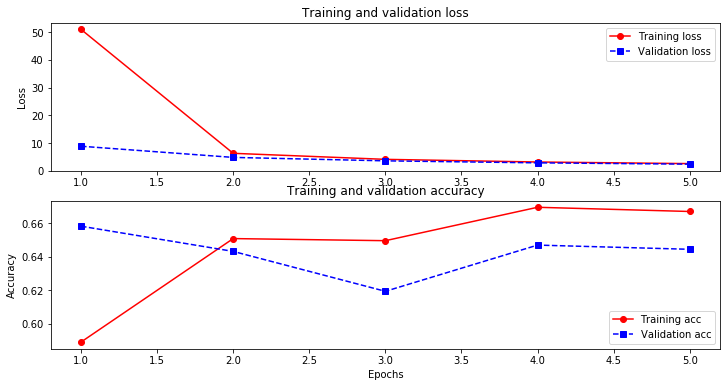

In [176]:
from utils.visualization import plot_history, plot_structure

plot_structure(model, 'word2vec.png')
plot_history(history.history)

In [177]:
from utils.prediction import predict

predict(model, test_ds, 'w2v_prediction.txt')

94/94 [==============================] - 1s 6ms/step


array([[0.60491925],
       [0.488619  ],
       [0.44910455],
       ...,
       [0.43873113],
       [0.5593084 ],
       [0.46170342]], dtype=float32)